In [1]:
! pip install kaggle
!pip install joblib

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


**INTIALIZING THE DATASET**

In [3]:
! kaggle datasets download -d kazanova/sentiment140

 96% 78.0M/80.9M [00:03<00:00, 31.7MB/s]
100% 80.9M/80.9M [00:03<00:00, 24.8MB/s]


In [4]:
from zipfile import ZipFile
data = '/content/sentiment140.zip'
with ZipFile(data,"r") as zip:
  zip.extractall()


**IMPORTING THE REQUIRED DEPENDENCIES**

In [5]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as TV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.svm as SVM
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**IDENTIFYING STOPWORDS**

In [7]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**LOADING DATAFRAME**


In [8]:
twitter_data = pd.read_csv("/content/sentiment_tweet.csv", encoding="ISO-8859-1", header=0,names=["Target","id","date","flag","user","text"])
twitter_data.head(5)

,Target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [9]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Target  1599999 non-null  int64 
 1   id      1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
twitter_data.shape

(1599999, 6)

In [11]:
twitter_data.isna().sum()

Target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

<Axes: xlabel='Target', ylabel='count'>

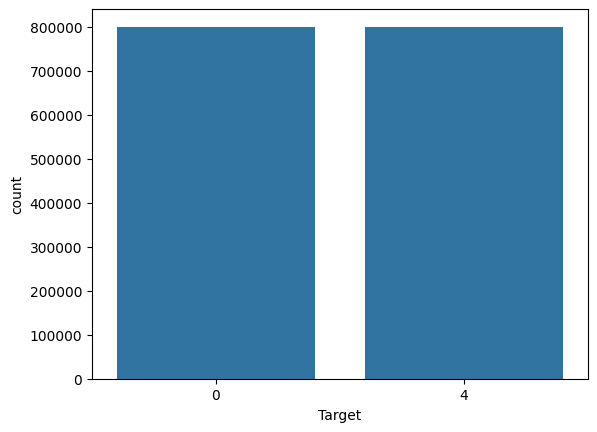

In [12]:
sns.countplot(x="Target", data=twitter_data)

In [13]:
twitter_data["Target"].value_counts()

4    800000
0    799999
Name: Target, dtype: int64

**We Need To Convert The 4 Into 1**

In [14]:
twitter_data.replace({"Target":{4:1}},inplace=True)
twitter_data["Target"].value_counts()

1    800000
0    799999
Name: Target, dtype: int64

**NOW WE KNOW THERE ARE**

800,000 POSITIVES

799,999 NEGATIVES


In [15]:
port_stem = PorterStemmer()

In [16]:
stop_words =set(stopwords.words("english"))
def stemming(content):
  stem_con = re.sub('[^a-zA-Z]',' ', content)
  stem_con = stem_con.lower()
  stem_con = stem_con.split()
  stem_con = [port_stem.stem(word) for word in stem_con if word not in stop_words ]
  stem_con = " ".join(stem_con)

  return stem_con

STEMMING THE TEXT

In [17]:
def process_chunk(data_chunk):
    return data_chunk.apply(stemming)


In [18]:
from joblib import Parallel, delayed

In [19]:
num_partitions = 10
data_split = np.array_split(twitter_data['text'], num_partitions)

twitter_data['content'] = pd.concat(Parallel(n_jobs=-1)(delayed(process_chunk)(chunk) for chunk in data_split))

In [20]:
twitter_data['content'].head(5)

0    upset updat facebook text might cri result sch...
1    kenichan dive mani time ball manag save rest g...
2                      whole bodi feel itchi like fire
3                        nationwideclass behav mad see
4                                  kwesidei whole crew
Name: content, dtype: object

**ASSIGNING X AND Y**

In [21]:
X = twitter_data['content']
y = twitter_data['Target']

**Converting the Text into Vectors**

In [22]:
vectorizer = TV()
X=vectorizer.fit_transform(X)

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [24]:
print(X_train)

  (0, 500679)	0.5064935157744348
  (0, 515336)	0.4168221249001028
  (0, 110557)	0.3200509450163996
  (0, 477748)	0.28276406738891985
  (0, 333479)	0.49008168495157123
  (0, 70310)	0.2762042835432959
  (0, 168415)	0.16648695706429553
  (0, 330976)	0.20772274409614916
  (1, 88318)	0.8009764898772433
  (1, 309797)	0.5469223080246679
  (1, 462403)	0.2435418888998374
  (2, 461572)	0.7460596825539395
  (2, 448133)	0.24894486327522805
  (2, 56085)	0.5271427489313122
  (2, 455167)	0.17623921351792754
  (2, 330976)	0.14322291384256383
  (2, 54249)	0.22796680445749154
  (3, 29580)	0.7750515263381016
  (3, 46235)	0.2866928162039438
  (3, 33852)	0.3411420073592643
  (3, 435041)	0.27966745197963055
  (3, 195463)	0.250635344275529
  (3, 150236)	0.2443205516857521
  (4, 307509)	0.6230737762778396
  (4, 192550)	0.31924591244937023
  :	:
  (1279993, 386729)	0.28002598577246196
  (1279994, 390523)	0.5324335133457098
  (1279994, 388051)	0.5324335133457098
  (1279994, 373868)	0.4923483098695524
  (1279994

In [25]:
print(X_test)

  (0, 449485)	0.7252283234427452
  (0, 182129)	0.3248118159523326
  (0, 490786)	0.36675665650403516
  (0, 485830)	0.2459227758266444
  (0, 156292)	0.26293461592480566
  (0, 443975)	0.2362061629090889
  (0, 462403)	0.2205101872615231
  (1, 133663)	0.8621087432859522
  (1, 347141)	0.349304768437247
  (1, 462403)	0.25484597131175246
  (1, 150236)	0.2642124607263756
  (2, 47160)	0.6554887774324193
  (2, 302750)	0.3355116679992271
  (2, 333479)	0.2454986844617896
  (2, 206998)	0.37469670067933175
  (2, 502600)	0.22090981521973443
  (2, 35963)	0.19581103580401862
  (2, 360981)	0.2408379570895927
  (2, 505890)	0.22815521203692882
  (2, 172873)	0.15760634933675818
  (2, 474893)	0.18723933832145978
  (3, 503073)	0.6122537579320478
  (3, 106841)	0.5113090830947075
  (3, 510127)	0.5137367944142677
  (3, 90966)	0.3158842565052703
  :	:
  (319997, 249949)	0.28657074743965366
  (319997, 453005)	0.2774073905771389
  (319997, 256177)	0.2869051748814394
  (319997, 105906)	0.2711770037644651
  (319997, 

**Training the model**


In [26]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [27]:
model.coef_

array([[-1.10264654, -1.47860673,  0.00681965, ...,  0.12035009,
        -0.14375864, -0.0829066 ]])

In [28]:
X_train_pred = model.predict(X_train)
model_train_accuracy = accuracy_score(y_train,X_train_pred)

In [29]:
model_train_accuracy

0.810401414376105

In [30]:
X_test_pred = model.predict(X_test)
model_test_accuracy = accuracy_score(y_test,X_test_pred)
model_test_accuracy

0.778346875

ACCURACY = 77.8%

IMPLEMENTING MLPCLASSIFIER

In [31]:
from sklearn.neural_network import MLPClassifier


In [32]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 8, 2), random_state=1)


In [33]:
clf.fit(X_train,y_train)
pred = clf.predict(X_train)
accuracy= accuracy_score(y_train,pred)
accuracy

0.5000003906253052

In [34]:
pred = clf.predict(X_test)
accuracy= accuracy_score(y_test,pred)
accuracy

0.5